### 🎯 Similitudes de los pesos 
Vamos a estudiar las similitudes de los pesos de las distintas capas de un modelo entrenado con todos los datos, y el modelo entrenado únicamente con los datos a retener.

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn import linear_model, model_selection
import pickle

# Suppress warnings and TensorFlow logs
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.utils import split_dataset
from tensorflow.python.client import device_lib

import keras_cv as kcv
from keras_cv import visualization
from keras_cv.models import ResNet18Backbone

Using TensorFlow backend


In [2]:
def set_device(mixed_precision=True, set_jit=False):
    # printed out the detected devices
    list_ld = device_lib.list_local_devices()
    for dev in list_ld:
        print(dev.name,dev.memory_limit)

    # get the lisf of physical devices
    physical_devices = tf.config.list_physical_devices(
        'GPU' if len(list_ld) - 1 else 'CPU'
    )
    # For GPU devices, configure related stuff
    if 'GPU' in physical_devices[-1]:
        tf.config.optimizer.set_jit(set_jit)
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_float16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
        for pd in physical_devices:
            tf.config.experimental.set_memory_growth(
                pd, True
            )
    strategy = tf.distribute.MirroredStrategy()
    return (strategy, physical_devices)

In [3]:
strategy, physical_devices = set_device(mixed_precision=True, set_jit=True)
physical_devices, strategy, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 4254072832
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')],
 '2.15.1')

___
Descargamos los modelos.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 128

(x_train, y_train), held_out = keras.datasets.cifar10.load_data()
test_set, val_set = keras.utils.split_dataset(held_out, left_size=0.2, seed=0)

def normalize(image, label, denorm=False):
    rescale = keras.layers.Rescaling(scale=1./255.)
    norms = keras.layers.Normalization(
        mean=[0.4914, 0.4822, 0.4465],
        variance=[np.square(0.2023), np.square(0.1994), np.square(0.2010)],
        invert=denorm,
        axis=-1,
    )

    if not denorm:
        image = rescale(image)
    return norms(image), label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(normalize)
train_ds = train_ds.shuffle(buffer_size=8*BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = val_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_set.map(normalize).batch(BATCH_SIZE).prefetch(AUTOTUNE)

def get_model(model_name):
    with strategy.scope():
        model = keras.Sequential(
            [
                ResNet18Backbone(include_rescaling=False, input_shape=(32, 32, 3)),
                keras.layers.GlobalMaxPooling2D(),
                keras.layers.Dense(10, activation="softmax", dtype=tf.float32),
            ]
        )
        model._name=model_name
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=metrics.SparseCategoricalAccuracy(name='accuracy'),
            jit_compile=True
        )

    return model

def change_model_names(model, name, suffix):
    model._name=name
    """
    Change all layer names in the model by adding the given suffix.
    
    Parameters:
        model (tf.keras.Model): The Keras model.
        suffix (str): The string to add to the layer names.
    """
    # Iterate through the layers of the model
    for layer in model.layers:
        # Change the layer name by adding the suffix
        layer._name += suffix
        # If the layer is a backbone, recursively change the sublayers' names
        if hasattr(layer, 'layers'):
            change_model_names(layer, layer._name, suffix)

In [5]:
full_model = keras.saving.load_model('resnet18_cifar10_2.keras')

In [17]:
forget_set, retain_set = keras.utils.split_dataset(train_ds.unbatch(), left_size=0.1)
forget_ds = forget_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
retain_ds = retain_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
print('A olvidar:', int(forget_set.cardinality()),', a retener:', int(retain_set.cardinality()))

retain_model = get_model('retain_model')
retain_model.fit(retain_ds, validation_data=val_ds, epochs=20)

change_model_names(retain_model, 'retain_model', '_retain')

A olvidar: 5000 , a retener: 45000
Epoch 1/20
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 62 all_reduces, num_devices = 1, group_size = 1, implementation = CommunicationImplementation.AUTO, num_pa

___
Descargamos y preparamos los modelos y sus capas.

In [18]:
# Extract the 'res_net_backbone' layer
res_net_backbone = full_model.get_layer('res_net_backbone_full')

# Extract layer names and weights for the backbone
backbone_layer_names = [layer.name for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]
backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn')]

# Extract layer names and weights for the entire model
layer_names = [layer.name for layer in full_model.layers]
layer_weights = [layer.get_weights() for layer in full_model.layers]

# Replace 'res_net_backbone' with its expanded layers that have weights
expanded_layer_names = []
full_model_weights = []

for name, weights in zip(layer_names, layer_weights):
    if name == 'res_net_backbone_full':
        expanded_layer_names.extend(backbone_layer_names)
        full_model_weights.extend(backbone_layer_weights)
    elif weights:  # Only add layers that have weights
        expanded_layer_names.append(name)
        full_model_weights.append(weights)

# Print or store the expanded layer names and weights
print("Expanded Layer Names:", expanded_layer_names)


Expanded Layer Names: ['conv1_conv', 'v2_stack_0_block1_1_conv', 'v2_stack_0_block1_2_conv', 'v2_stack_0_block2_1_conv', 'v2_stack_0_block2_2_conv', 'v2_stack_1_block1_1_conv', 'v2_stack_1_block1_0_conv', 'v2_stack_1_block1_2_conv', 'v2_stack_1_block2_1_conv', 'v2_stack_1_block2_2_conv', 'v2_stack_2_block1_1_conv', 'v2_stack_2_block1_0_conv', 'v2_stack_2_block1_2_conv', 'v2_stack_2_block2_1_conv', 'v2_stack_2_block2_2_conv', 'v2_stack_3_block1_1_conv', 'v2_stack_3_block1_0_conv', 'v2_stack_3_block1_2_conv', 'v2_stack_3_block2_1_conv', 'v2_stack_3_block2_2_conv', 'dense_full']


In [19]:
# Extract the 'res_net_backbone' layer
res_net_backbone = retain_model.get_layer('res_net_backbone_retain')

# Extract layer names and weights for the backbone
backbone_layer_names = [layer.name for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn_retain')]
backbone_layer_weights = [layer.get_weights() for layer in res_net_backbone.layers if layer.count_params() > 0 and not layer.name.endswith('_bn_retain')]

# Extract layer names and weights for the entire model
layer_names = [layer.name for layer in retain_model.layers]
layer_weights = [layer.get_weights() for layer in retain_model.layers]

# Replace 'res_net_backbone' with its expanded layers that have weights
expanded_layer_names = []
retain_model_weights = []

for name, weights in zip(layer_names, layer_weights):
    if name == 'res_net_backbone_retain':
        expanded_layer_names.extend(backbone_layer_names)
        retain_model_weights.extend(backbone_layer_weights)
    elif weights:  # Only add layers that have weights
        expanded_layer_names.append(name)
        retain_model_weights.append(weights)

# Print or store the expanded layer names and weights
print("Expanded Layer Names:", expanded_layer_names)

Expanded Layer Names: ['conv1_conv_retain', 'v2_stack_0_block1_1_conv_retain', 'v2_stack_0_block1_2_conv_retain', 'v2_stack_0_block2_1_conv_retain', 'v2_stack_0_block2_2_conv_retain', 'v2_stack_1_block1_1_conv_retain', 'v2_stack_1_block1_0_conv_retain', 'v2_stack_1_block1_2_conv_retain', 'v2_stack_1_block2_1_conv_retain', 'v2_stack_1_block2_2_conv_retain', 'v2_stack_2_block1_1_conv_retain', 'v2_stack_2_block1_0_conv_retain', 'v2_stack_2_block1_2_conv_retain', 'v2_stack_2_block2_1_conv_retain', 'v2_stack_2_block2_2_conv_retain', 'v2_stack_3_block1_1_conv_retain', 'v2_stack_3_block1_0_conv_retain', 'v2_stack_3_block1_2_conv_retain', 'v2_stack_3_block2_1_conv_retain', 'v2_stack_3_block2_2_conv_retain', 'dense_1_retain']


___
Calculamos CosSim de los parámetros para cada capa.

In [20]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
    return dot(a, b)/(norm(a)*norm(b))

In [21]:
layer_names=['conv1',
 '0_1_1_conv',
 '0_1_2_conv',
 '0_2_1_conv',
 '0_2_2_conv',
 '1_1_1_conv',
 '1_1_0_conv',
 '1_1_2_conv',
 '1_2_1_conv',
 '1_2_2_conv',
 '2_1_1_conv',
 '2_1_0_conv',
 '2_1_2_conv',
 '2_2_1_conv',
 '2_2_2_conv',
 '3_1_1_conv',
 '3_1_0_conv',
 '3_1_2_conv',
 '3_2_1_conv',
 '3_2_2_conv',
 'dense_out']

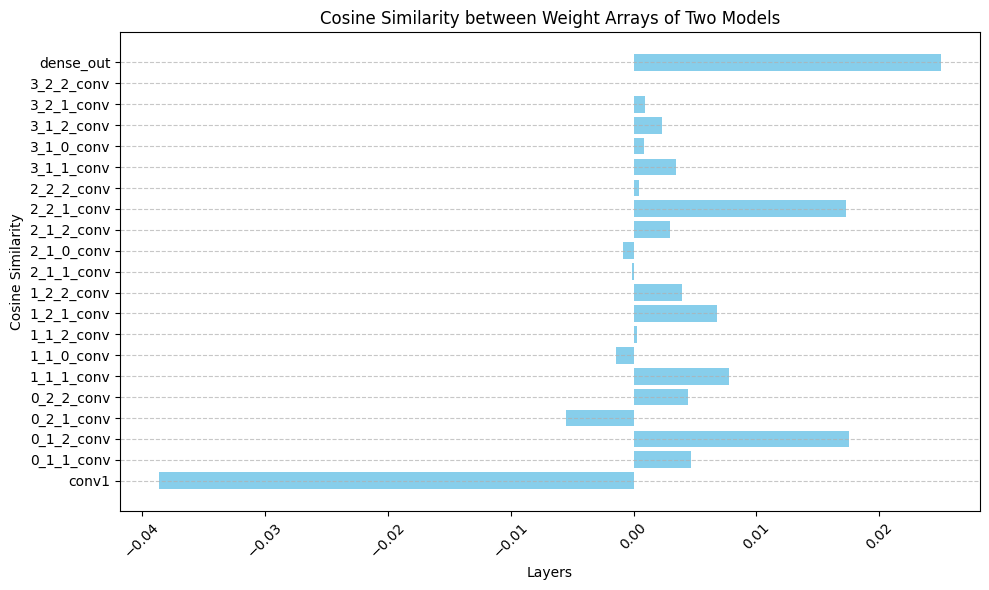

In [22]:
import matplotlib.pyplot as plt
from datetime import datetime

# Initialize list to store cosine similarities
similarities = []

def flatten_arrays(arrays):
    flattened_elements = []
    for arr in arrays:
        flattened_elements.extend(arr.flatten())
    return flattened_elements

# Compute cosine similarity for each layer
for w1, w2 in zip(full_model_weights, retain_model_weights):
    w1=flatten_arrays(w1)
    w2=flatten_arrays(w2)
    similarity = cos_sim(w1, w2)
    similarities.append(similarity)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(layer_names, similarities, color='skyblue')
plt.xlabel('Layers')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity between Weight Arrays of Two Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

filename = datetime.now().strftime("plot_%Y%m%d_%H%M%S.png")
plt.savefig('weight_sim_plots/'+filename)

plt.show()

In [23]:
import pickle

# Getting back the objects:
with open('w_sim_2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    total_sim = pickle.load(f)

total_sim.append(similarities)

# Saving the objects:
with open('w_sim_2.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(total_sim, f)

print(len(total_sim))

10


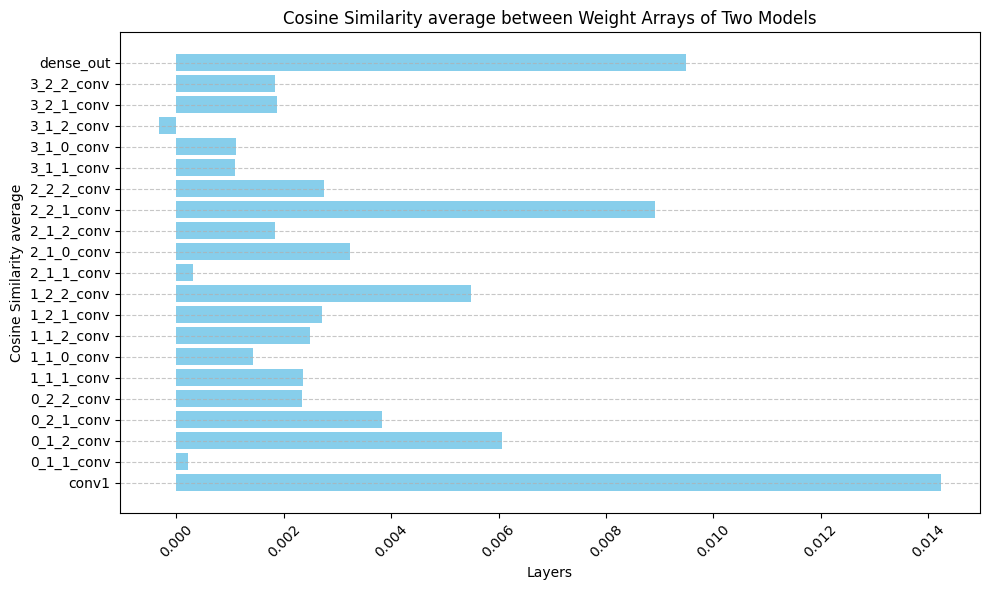

In [24]:
avg_sim = [sum(group) / len(group) for group in zip(*total_sim)]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(layer_names, avg_sim, color='skyblue')
plt.xlabel('Layers')
plt.ylabel('Cosine Similarity average')
plt.title('Cosine Similarity average between Weight Arrays of Two Models')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

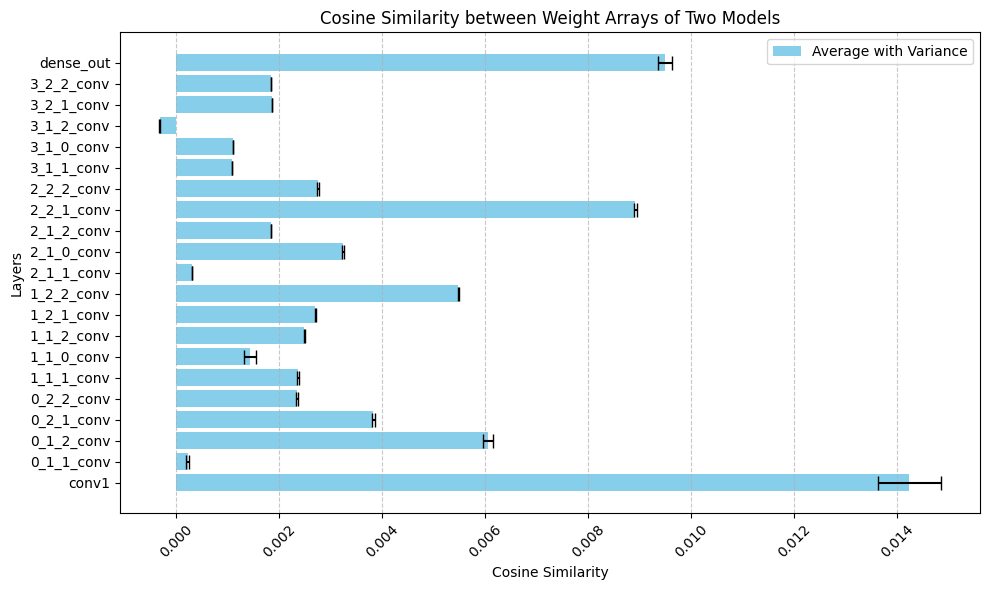

In [25]:
import statistics

# Getting back the objects:
with open('w_sim_2.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    total_sim = pickle.load(f)

avg_sim = [sum(group) / len(group) for group in zip(*total_sim)]

# Calculate the variance for each position
variances = [statistics.variance(group) for group in zip(*total_sim)]

# Plotting
plt.figure(figsize=(10, 6))

# Plot average
plt.barh(layer_names, avg_sim, xerr=variances, color='skyblue', capsize=5, label='Average with Variance')

plt.xlabel('Cosine Similarity')
plt.ylabel('Layers')
plt.title('Cosine Similarity between Weight Arrays of Two Models')
plt.xticks(rotation=45)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend()

plt.show()
